In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
from sklearn.model_selection import StratifiedGroupKFold
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 281
Categorical features: 6


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 281
Categorical Columns: 6


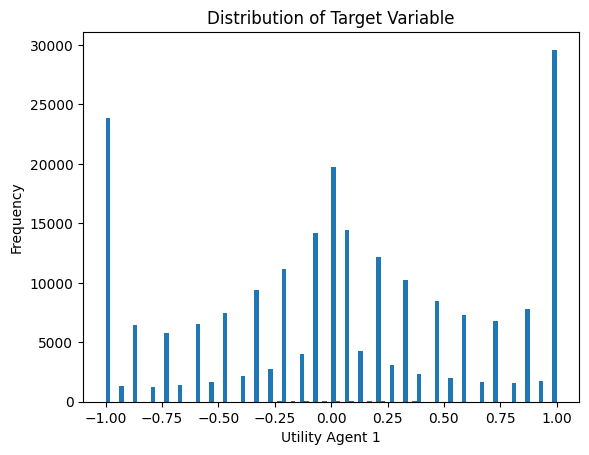

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model


Fold 1
[50]	valid_0's rmse: 0.465191
[100]	valid_0's rmse: 0.448695
[150]	valid_0's rmse: 0.440749
[200]	valid_0's rmse: 0.436184
[250]	valid_0's rmse: 0.431487
[300]	valid_0's rmse: 0.429485
[350]	valid_0's rmse: 0.428285
[400]	valid_0's rmse: 0.427266
[450]	valid_0's rmse: 0.426437
[500]	valid_0's rmse: 0.425692
[550]	valid_0's rmse: 0.425102
[600]	valid_0's rmse: 0.424353
[650]	valid_0's rmse: 0.423671
[700]	valid_0's rmse: 0.423032
[750]	valid_0's rmse: 0.422776
[800]	valid_0's rmse: 0.422331
[850]	valid_0's rmse: 0.422287
[900]	valid_0's rmse: 0.421925
[950]	valid_0's rmse: 0.421718
[1000]	valid_0's rmse: 0.421463
[1050]	valid_0's rmse: 0.421103
[1100]	valid_0's rmse: 0.421066
[1150]	valid_0's rmse: 0.420936
[1200]	valid_0's rmse: 0.420781
[1250]	valid_0's rmse: 0.420677
[1300]	valid_0's rmse: 0.42049
[1350]	valid_0's rmse: 0.420413
[1400]	valid_0's rmse: 0.420448
[1450]	valid_0's rmse: 0.420484
[1500]	valid_0's rmse: 0.420506
[1550]	valid_0's rmse: 0.420684
[1600]	valid_0's rmse:

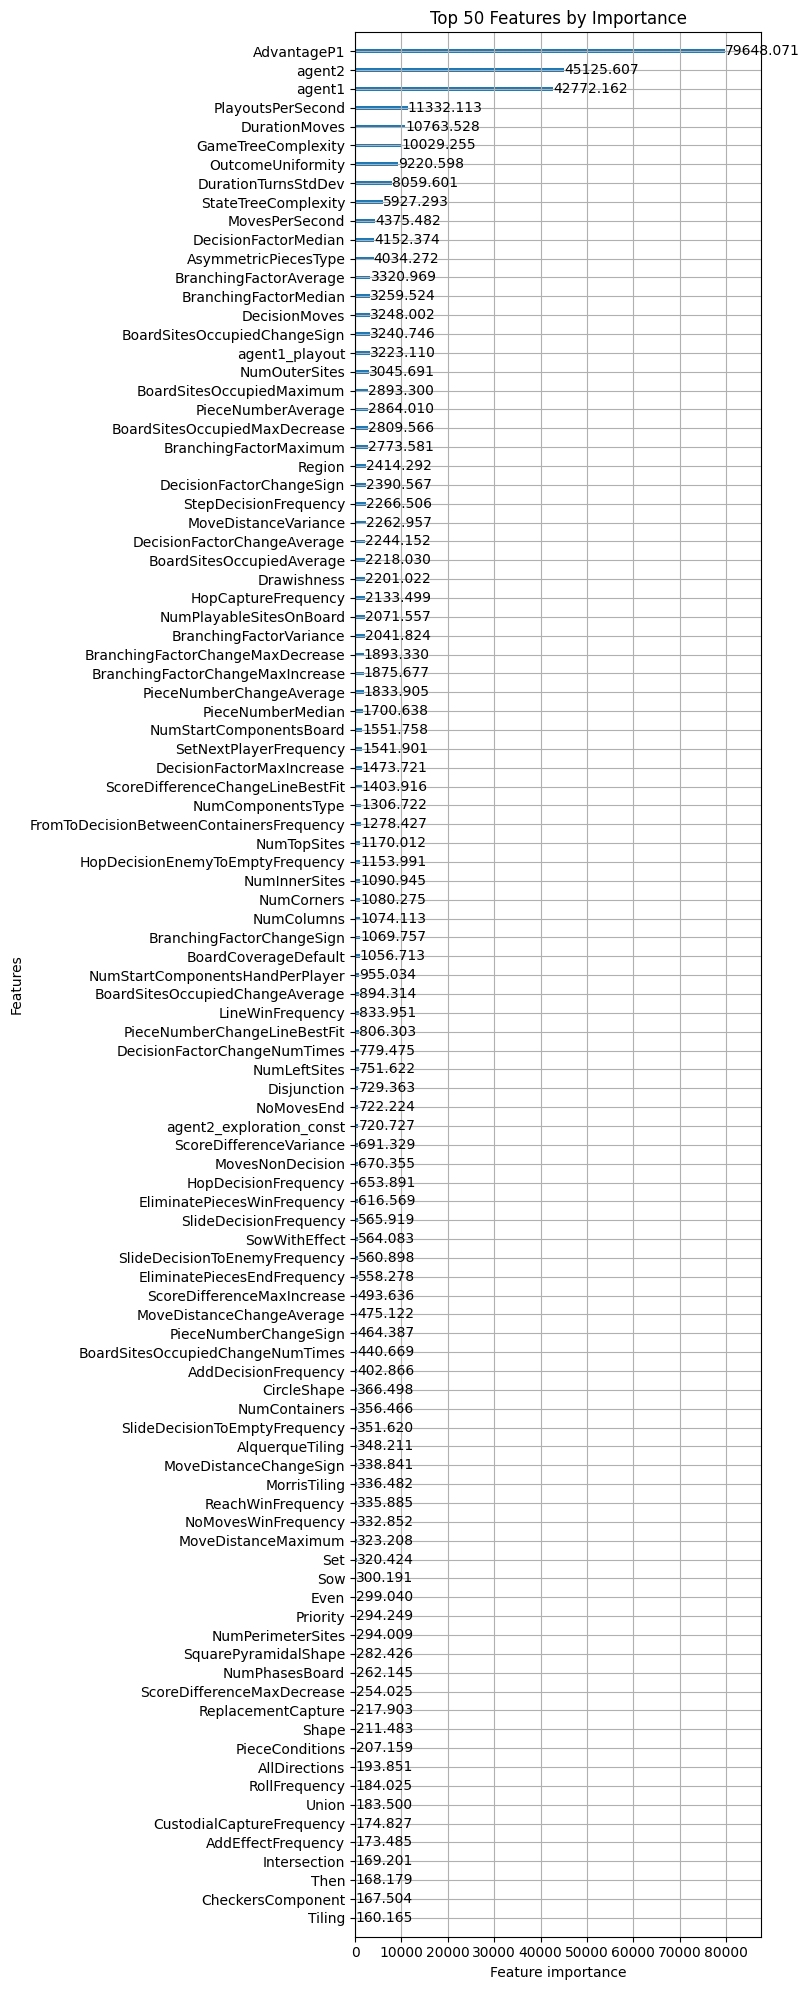

Fold 1 - RMSE: 0.4196670310186305
Fold 2
[50]	valid_0's rmse: 0.470366
[100]	valid_0's rmse: 0.452916
[150]	valid_0's rmse: 0.449144
[200]	valid_0's rmse: 0.446363
[250]	valid_0's rmse: 0.442963
[300]	valid_0's rmse: 0.440598
[350]	valid_0's rmse: 0.438807
[400]	valid_0's rmse: 0.437388
[450]	valid_0's rmse: 0.435914
[500]	valid_0's rmse: 0.435583
[550]	valid_0's rmse: 0.434819
[600]	valid_0's rmse: 0.433573
[650]	valid_0's rmse: 0.433002
[700]	valid_0's rmse: 0.432743
[750]	valid_0's rmse: 0.432391
[800]	valid_0's rmse: 0.431952
[850]	valid_0's rmse: 0.431924
[900]	valid_0's rmse: 0.43164
[950]	valid_0's rmse: 0.431348
[1000]	valid_0's rmse: 0.430996
[1050]	valid_0's rmse: 0.430819
[1100]	valid_0's rmse: 0.430512
[1150]	valid_0's rmse: 0.430575
[1200]	valid_0's rmse: 0.430515
[1250]	valid_0's rmse: 0.430317
[1300]	valid_0's rmse: 0.430187
[1350]	valid_0's rmse: 0.430111
[1400]	valid_0's rmse: 0.429956
[1450]	valid_0's rmse: 0.429912
[1500]	valid_0's rmse: 0.429812
[1550]	valid_0's rms

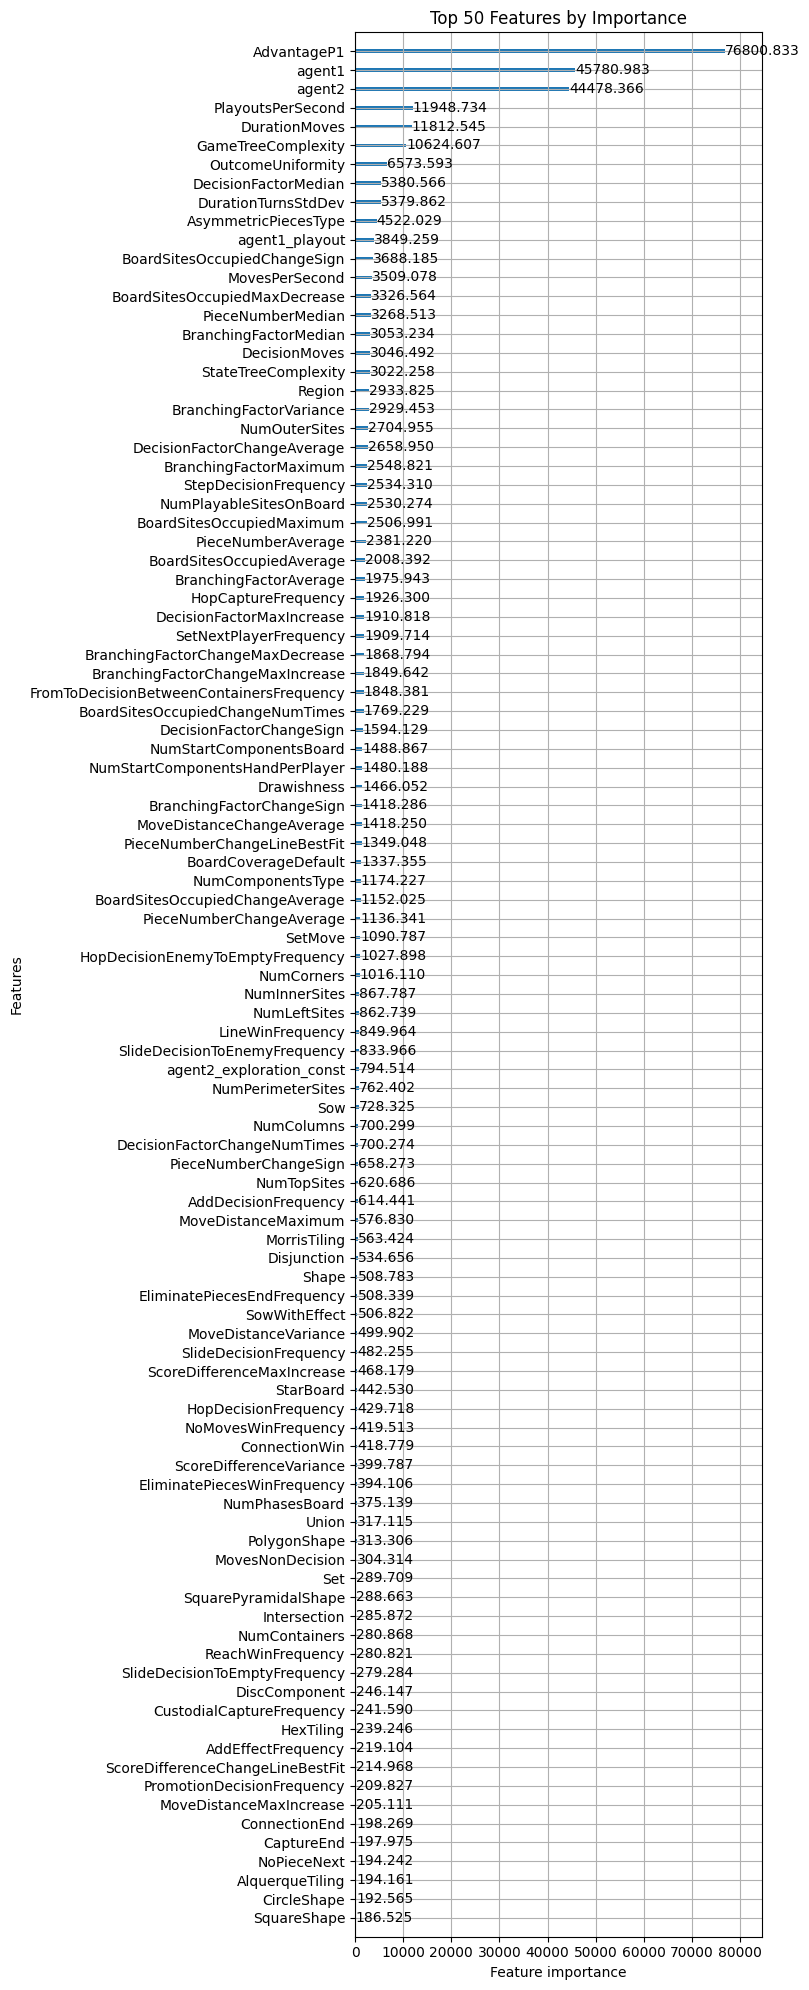

Fold 2 - RMSE: 0.42867860897750193
Fold 3
[50]	valid_0's rmse: 0.480542
[100]	valid_0's rmse: 0.468542
[150]	valid_0's rmse: 0.462948
[200]	valid_0's rmse: 0.459382
[250]	valid_0's rmse: 0.455964
[300]	valid_0's rmse: 0.453377
[350]	valid_0's rmse: 0.451913
[400]	valid_0's rmse: 0.450535
[450]	valid_0's rmse: 0.449513
[500]	valid_0's rmse: 0.449132
[550]	valid_0's rmse: 0.448059
[600]	valid_0's rmse: 0.447401
[650]	valid_0's rmse: 0.446743
[700]	valid_0's rmse: 0.446092
[750]	valid_0's rmse: 0.445729
[800]	valid_0's rmse: 0.44564
[850]	valid_0's rmse: 0.445536
[900]	valid_0's rmse: 0.445214
[950]	valid_0's rmse: 0.445129
[1000]	valid_0's rmse: 0.445154
[1050]	valid_0's rmse: 0.445022
[1100]	valid_0's rmse: 0.444714
[1150]	valid_0's rmse: 0.444488
[1200]	valid_0's rmse: 0.444374
[1250]	valid_0's rmse: 0.44423
[1300]	valid_0's rmse: 0.444229
[1350]	valid_0's rmse: 0.444064
[1400]	valid_0's rmse: 0.444048
[1450]	valid_0's rmse: 0.443906
[1500]	valid_0's rmse: 0.44394
[1550]	valid_0's rmse

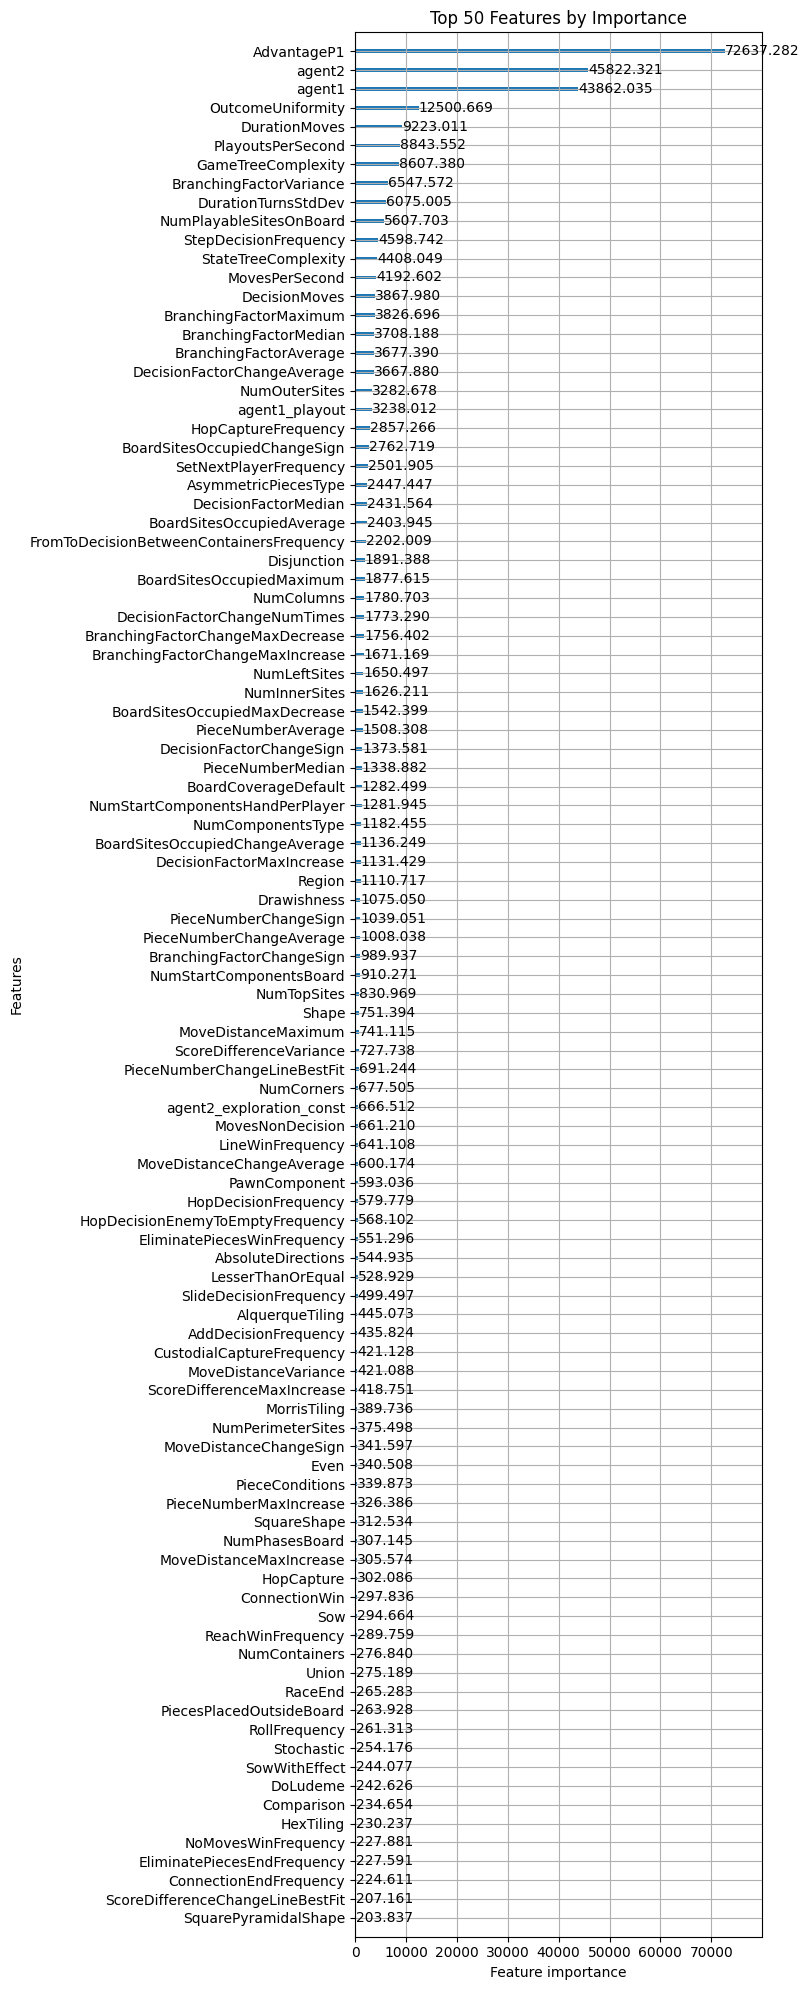

Fold 3 - RMSE: 0.4420542875745251
Fold 4
[50]	valid_0's rmse: 0.468558
[100]	valid_0's rmse: 0.453439
[150]	valid_0's rmse: 0.443767
[200]	valid_0's rmse: 0.440331
[250]	valid_0's rmse: 0.437359
[300]	valid_0's rmse: 0.434887
[350]	valid_0's rmse: 0.433425
[400]	valid_0's rmse: 0.431741
[450]	valid_0's rmse: 0.430719
[500]	valid_0's rmse: 0.429394
[550]	valid_0's rmse: 0.42862
[600]	valid_0's rmse: 0.427766
[650]	valid_0's rmse: 0.427277
[700]	valid_0's rmse: 0.426601
[750]	valid_0's rmse: 0.425933
[800]	valid_0's rmse: 0.425414
[850]	valid_0's rmse: 0.424969
[900]	valid_0's rmse: 0.424816
[950]	valid_0's rmse: 0.424724
[1000]	valid_0's rmse: 0.424472
[1050]	valid_0's rmse: 0.424174
[1100]	valid_0's rmse: 0.424002
[1150]	valid_0's rmse: 0.423792
[1200]	valid_0's rmse: 0.423554
[1250]	valid_0's rmse: 0.423298
[1300]	valid_0's rmse: 0.423579
[1350]	valid_0's rmse: 0.423484
[1400]	valid_0's rmse: 0.423291
[1450]	valid_0's rmse: 0.423379
[1500]	valid_0's rmse: 0.423356
[1550]	valid_0's rms

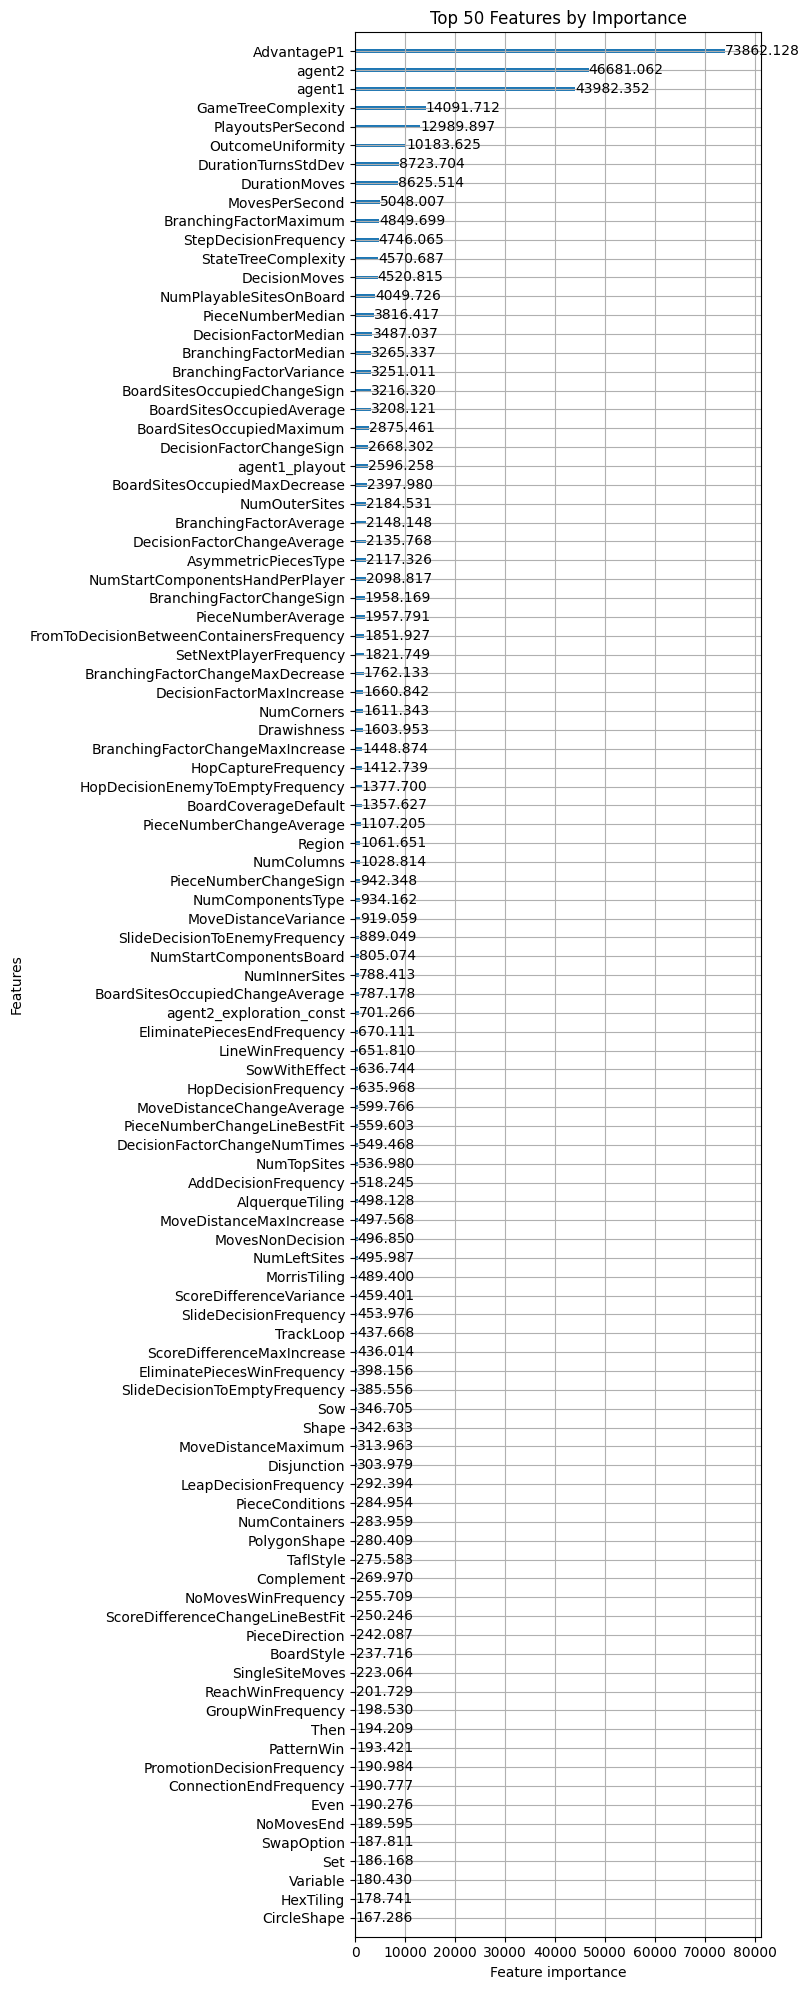

Fold 4 - RMSE: 0.4224745466495753
Fold 5
[50]	valid_0's rmse: 0.465103
[100]	valid_0's rmse: 0.4487
[150]	valid_0's rmse: 0.44082
[200]	valid_0's rmse: 0.436129
[250]	valid_0's rmse: 0.433024
[300]	valid_0's rmse: 0.431314
[350]	valid_0's rmse: 0.429001
[400]	valid_0's rmse: 0.428365
[450]	valid_0's rmse: 0.427228
[500]	valid_0's rmse: 0.426185
[550]	valid_0's rmse: 0.425599
[600]	valid_0's rmse: 0.42522
[650]	valid_0's rmse: 0.42483
[700]	valid_0's rmse: 0.424597
[750]	valid_0's rmse: 0.424362
[800]	valid_0's rmse: 0.424187
[850]	valid_0's rmse: 0.424082
[900]	valid_0's rmse: 0.424023
[950]	valid_0's rmse: 0.424072
[1000]	valid_0's rmse: 0.423916
[1050]	valid_0's rmse: 0.423627
[1100]	valid_0's rmse: 0.423514
[1150]	valid_0's rmse: 0.423456
[1200]	valid_0's rmse: 0.423237
[1250]	valid_0's rmse: 0.422818
[1300]	valid_0's rmse: 0.422735
[1350]	valid_0's rmse: 0.422556
[1400]	valid_0's rmse: 0.422626
[1450]	valid_0's rmse: 0.422536
[1500]	valid_0's rmse: 0.4224
[1550]	valid_0's rmse: 0.4

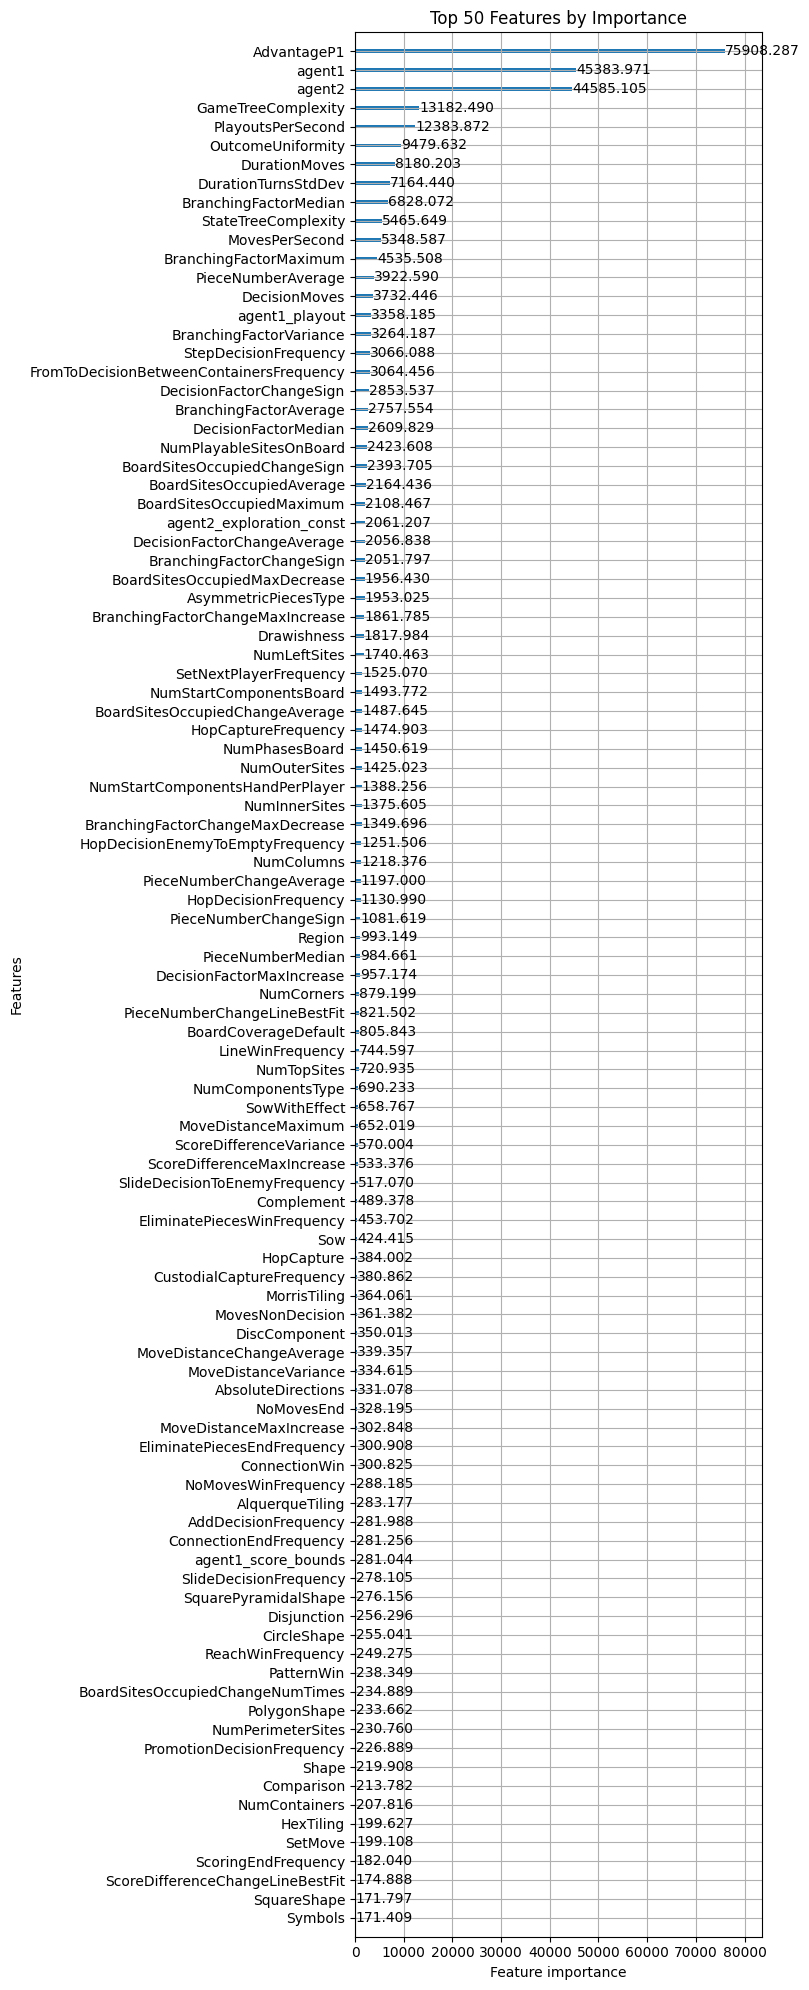

Fold 5 - RMSE: 0.42162559169595515
List of oof scores: [0.4196670310186305, 0.42867860897750193, 0.4420542875745251, 0.4224745466495753, 0.42162559169595515]
Average oof score: 0.42690001318323756


In [6]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        num_folds=5,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=2112, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'max_depth': 10,
        'learning_rate': 0.1,
        'reg_alpha': 1e-1,
        'reg_lambda': 1e-1,
        'feature_fraction': 0.8,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []
    feature_importances = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=2000,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=50),
            ]
        )
        lgb.plot_importance(model, figsize=(8, 20), importance_type='gain', max_num_features=100)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    # save oof predictions
    oof.to_csv(path_results / 'oof_lightgbm.csv', index=False)
    
    return trained_models, oof, oof_scores

# Train the models
trained_models, oof, oof_scores = train_models(df_train, numerical_cols, categorical_cols)

# save oof predictions
oof.to_csv(path_results / 'oof_lightgbm.csv', index=False)

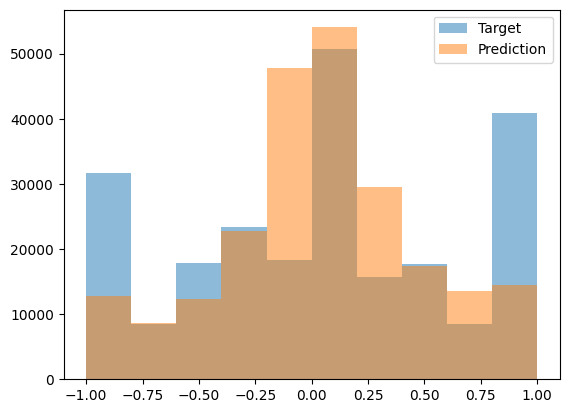

In [7]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [8]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [9]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [ ]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

In [10]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [12]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open('./lightgbm_predict.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***